Import necessari:

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.spatial.distance import mahalanobis
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from skimage.feature import hog
from torchvision.io import read_image
from torchvision.transforms import functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score,classification_report
from sklearn.decomposition import PCA

from collections import defaultdict

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


from collections import Counter
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
from PIL import Image


Set Up

In [2]:
def load_features(npz_path):
    data = np.load(npz_path, allow_pickle=True)
    return data['features'], data['labels'], data.get('filenames', [f"img_{i}" for i in range(len(data['features']))])


feat_matrix_part1, lbls_part1, flname_part1 = load_features(
    "hog_features_part1.npz")
feat_matrix_part2, lbls_part2, flname_part2 = load_features(
    "hog_features_part2.npz")

Seconda implementazione

Task 2 : 

In [3]:
# === Funzione: Estrazione HOG ===
def extract_hog_features_from_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))  # dimensione standard

    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

In [4]:
def process_and_save_features(base_folder, subfolders, output_file):
    """Estrae le feature da immagini organizzate in sottocartelle e le salva in un file .npz."""
    all_features, all_filenames, all_labels = [], [], []

    for label in subfolders:
        folder_path = os.path.join(base_folder, label)
        print(f"[INFO] Elaboro cartella: {label}")
        for filename in os.listdir(folder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(folder_path, filename)
                features = extract_hog_features_from_image(img_path)
                if features is not None:
                    all_features.append(features)
                    all_filenames.append(filename)
                    all_labels.append(label)

    np.savez(output_file,
             features=np.array(all_features),
             filenames=np.array(all_filenames),
             labels=np.array(all_labels))
    print(f"[SALVATO] Features salvate in {output_file}")

In [5]:
# Parametri
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]

# Estrazione e salvataggio
process_and_save_features("Part1", subfolders, "hog_features_part1.npz")
process_and_save_features("Part2", subfolders, "hog_features_part2.npz")

[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in hog_features_part1.npz
[INFO] Elaboro cartella: brain_glioma
[INFO] Elaboro cartella: brain_menin
[INFO] Elaboro cartella: brain_tumor
[SALVATO] Features salvate in hog_features_part2.npz


Task 3

Distanza coseno:

[RISULTATI] Le 11 immagini più simili a 'brain_glioma_0001.jpg':
- brain_glioma_0001.jpg (similarità: 1.0000)
- brain_glioma_0102.jpg (similarità: 0.6209)
- brain_glioma_0959.jpg (similarità: 0.6202)
- brain_glioma_0633.jpg (similarità: 0.6159)
- brain_menin_0454.jpg (similarità: 0.5989)
- brain_glioma_0480.jpg (similarità: 0.5878)
- brain_glioma_0918.jpg (similarità: 0.5872)
- brain_glioma_0820.jpg (similarità: 0.5812)
- brain_glioma_0377.jpg (similarità: 0.5709)
- brain_glioma_0032.jpg (similarità: 0.5671)
- brain_glioma_0496.jpg (similarità: 0.5626)


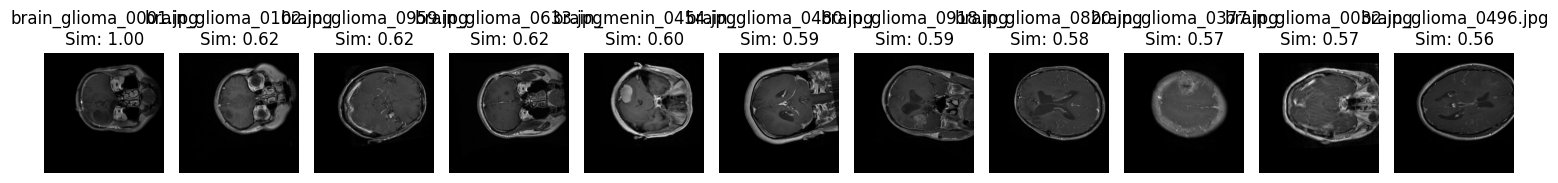

In [6]:

# === Funzione: Estrai feature HOG dalla query ===
def extract_hog_features(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERRORE] Immagine non trovata o non valida: {img_path}")
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))
    features, _ = hog(resized,
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=True,
                      block_norm='L2-Hys')
    return features

# === Funzione: Visualizza immagini simili ===
def show_similar_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, score) in zip(axes, results):
        img_path = None
        # Cerca nei sottocartelle
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nSim: {score:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Funzione principale ===
def find_similar_images_npz(query_path, k, npz_path="hog_features_part1.npz", base_folder="Part1"):
    # Carica i dati dal file .npz
    data = np.load(npz_path, allow_pickle=True)
    X = data["features"]
    filenames = data["filenames"]

    # Estrai le feature dalla query
    query_features = extract_hog_features(query_path)

    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # Calcola la similarità coseno
    similarities = cosine_similarity([query_features], X)[0]

    # Ordina per similarità decrescente
    sorted_indices = np.argsort(similarities)[::-1]
    top_k = sorted_indices[:k]

    results = [(filenames[i], similarities[i]) for i in top_k]

    print(f"[RISULTATI] Le {k} immagini più simili a '{os.path.basename(query_path)}':")
    for fname, score in results:
        print(f"- {fname} (similarità: {score:.4f})")

    show_similar_images(results, base_folder)

# === ESEMPIO DI USO ===
query_image = "Part1/brain_glioma/brain_glioma_0001.jpg"
k = 11
find_similar_images_npz(query_image, k)


Distanza euclidea:

[RISULTATI] Le 11 immagini più simili a 'brain_glioma_0001.jpg':
- brain_glioma_0001.jpg (distanza: 0.0000)
- brain_glioma_0959.jpg (distanza: 10.9962)
- brain_glioma_0377.jpg (distanza: 11.3744)
- brain_glioma_0480.jpg (distanza: 11.4295)
- brain_glioma_0820.jpg (distanza: 11.5400)
- brain_menin_0454.jpg (distanza: 11.5812)
- brain_glioma_0201.jpg (distanza: 11.5897)
- brain_glioma_0633.jpg (distanza: 11.6258)
- brain_glioma_0102.jpg (distanza: 11.6350)
- brain_glioma_0542.jpg (distanza: 11.7111)
- brain_glioma_0918.jpg (distanza: 11.7461)


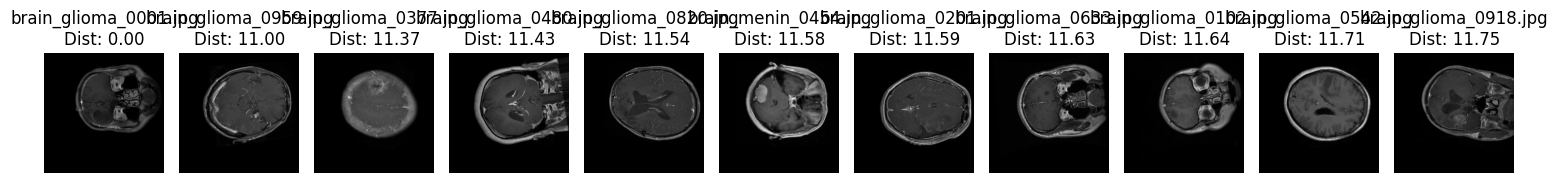

In [7]:


# === Funzione: Visualizza immagini simili ===
def show_similar_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, dist) in zip(axes, results):
        img_path = None
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nDist: {dist:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Funzione principale ===
def find_similar_images_npz(query_path, k, npz_path="hog_features_part1.npz", base_folder="Part1"):
    # Carica i dati dal file .npz
    data = np.load(npz_path, allow_pickle=True)
    X = data['features']
    filenames = data['filenames']

    # Estrai feature della query
    query_features = extract_hog_features(query_path)
    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # Calcola distanza euclidea
    distances = euclidean_distances([query_features], X)[0]

    # Ordina per distanza crescente
    sorted_indices = np.argsort(distances)
    top_k = sorted_indices[:k]

    results = [(filenames[i], distances[i]) for i in top_k]

    print(f"[RISULTATI] Le {k} immagini più simili a '{os.path.basename(query_path)}':")
    for fname, dist in results:
        print(f"- {fname} (distanza: {dist:.4f})")

    show_similar_images(results, base_folder)

# === Esempio di utilizzo ===
query_image = "Part1/brain_glioma/brain_glioma_0001.jpg"
k = 11
find_similar_images_npz(query_image, k)


QUESTO CODICE SOTTO LO TENIAMO? 

In [8]:
# === Distanza Chi-Squared ===
def chi2_distance(a, b, eps=1e-10):
    return 0.5 * np.sum(((a - b) ** 2) / (a + b + eps))

# === Similarità Correlazione ===
def correlation_similarity(a, B):
    a_mean = a - np.mean(a)
    B_mean = B - np.mean(B, axis=1, keepdims=True)
    num = np.dot(B_mean, a_mean)
    denom = np.linalg.norm(B_mean, axis=1) * np.linalg.norm(a_mean)
    return num / (denom + 1e-10)

# === Visualizza immagini ===
def show_images(results, base_folder):
    fig, axes = plt.subplots(1, len(results), figsize=(15, 5))
    if len(results) == 1:
        axes = [axes]
    for ax, (filename, score) in zip(axes, results):
        img_path = None
        for subdir in os.listdir(base_folder):
            candidate_path = os.path.join(base_folder, subdir, filename)
            if os.path.exists(candidate_path):
                img_path = candidate_path
                break
        if img_path:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"{filename}\nScore: {score:.2f}")
            ax.axis('off')
        else:
            ax.set_title(f"Non trovata: {filename}")
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# === Trova immagini simili ===
def find_similar_images_npz(img_path, k, metric):

    query_features = extract_hog_features_from_image(img_path)
    if query_features is None:
        print("[ERRORE] Impossibile estrarre feature dalla query.")
        return

    # === Calcolo distanza/similarità ===
    if metric == "cosine":
        similarities = cosine_similarity([query_features], feat_matrix_part1)[0]
        sorted_indices = np.argsort(similarities)[::-1]  # similarità -> decrescente
        results = [(flname_part1[i], similarities[i]) for i in sorted_indices[:k]]
    elif metric == "euclidean":
        distances = euclidean_distances([query_features], feat_matrix_part1)[0]
        sorted_indices = np.argsort(distances)  # distanza -> crescente
        results = [(flname_part1[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "manhattan":
        distances = manhattan_distances([query_features], feat_matrix_part1)[0]
        sorted_indices = np.argsort(distances)
        results = [(flname_part1[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "chi2":
        distances = np.array([chi2_distance(query_features, feat_matrix_part1) for x in feat_matrix_part1])
        sorted_indices = np.argsort(distances)
        results = [(flname_part1[i], distances[i]) for i in sorted_indices[:k]]
    elif metric == "correlation":
        similarities = correlation_similarity(query_features, feat_matrix_part1)
        sorted_indices = np.argsort(similarities)[::-1]
        results = [(flname_part1[i], similarities[i]) for i in sorted_indices[:k]]
    else:
        print(f"[ERRORE] Metrica non supportata: {metric}")
        return

    print(f"[RISULTATI - {metric}] Le {k} immagini più simili a '{os.path.basename(img_path)}':")
    for fname, score in results:
        print(f"- {fname} (score: {score:.4f})")

    show_similar_images(results, base_folder)

# === Esempio di uso ===
query_image = "Part1/brain_menin/brain_menin_0013.jpg"
k = 5
find_similar_images_npz(query_image, k, metric="cosine")  # Cambia qui per provare cosine, euclidean, etc.


[RISULTATI - cosine] Le 5 immagini più simili a 'brain_menin_0013.jpg':
- brain_menin_0013.jpg (score: 1.0000)
- brain_glioma_0207.jpg (score: 0.7652)
- brain_menin_0582.jpg (score: 0.7516)
- brain_menin_0801.jpg (score: 0.7464)
- brain_tumor_1001.jpg (score: 0.7435)


NameError: name 'base_folder' is not defined

In [9]:
def find_k_similar(base_folder, img_path, k):
    """Trova le k immagini più simili in base alla distanza euclidea."""
    query_feature = extract_hog_features_from_image(img_path)
    if query_feature is None:
        return

    query_feature = np.array(query_feature).reshape(1, -1)
    distances = euclidean_distances(feat_matrix_part1, query_feature).flatten()
    top_k_idx = np.argsort(distances)[:k]

    print(f"\nTop {k} immagini simili a: {img_path}")
    for rank, idx in enumerate(top_k_idx):
        print(f"{rank+1}. {flname_part1[idx]} | Classe: {lbls_part1[idx]} | Distanza: {distances[idx]:.2f}")

    # Visualizzazione
    fig, axs = plt.subplots(1, k+1, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    axs[0].set_title("Query")
    axs[0].axis('off')

    for i, idx in enumerate(top_k_idx):
        img_match = cv2.imread(os.path.join(base_folder, lbls_part1[idx], flname_part1[idx]))
        axs[i+1].imshow(cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB))
        axs[i+1].set_title(f"Rank {i+1}\nD={distances[idx]:.2f}")
        axs[i+1].axis('off')

    plt.tight_layout()
    plt.show()


Top 25 immagini simili a: Part1/brain_glioma/brain_glioma_0005.jpg
1. brain_glioma_0005.jpg | Classe: brain_glioma | Distanza: 0.00
2. brain_glioma_0637.jpg | Classe: brain_glioma | Distanza: 11.08
3. brain_glioma_0652.jpg | Classe: brain_glioma | Distanza: 11.20
4. brain_glioma_0568.jpg | Classe: brain_glioma | Distanza: 11.23
5. brain_menin_0107.jpg | Classe: brain_menin | Distanza: 11.31
6. brain_glioma_0285.jpg | Classe: brain_glioma | Distanza: 11.35
7. brain_menin_0377.jpg | Classe: brain_menin | Distanza: 11.35
8. brain_glioma_0282.jpg | Classe: brain_glioma | Distanza: 11.42
9. brain_glioma_0208.jpg | Classe: brain_glioma | Distanza: 11.42
10. brain_glioma_0786.jpg | Classe: brain_glioma | Distanza: 11.43
11. brain_glioma_0258.jpg | Classe: brain_glioma | Distanza: 11.47
12. brain_glioma_0367.jpg | Classe: brain_glioma | Distanza: 11.56
13. brain_tumor_0918.jpg | Classe: brain_tumor | Distanza: 11.57
14. brain_glioma_0294.jpg | Classe: brain_glioma | Distanza: 11.60
15. brain_

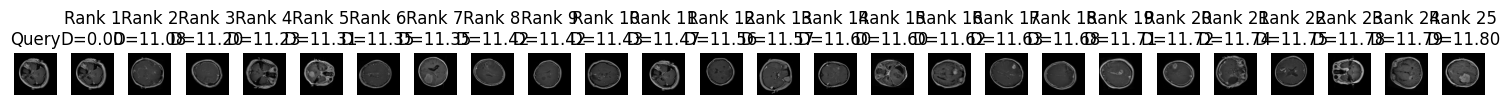

In [10]:
base_folder = "Part1"
query_img = "Part1/brain_glioma/brain_glioma_0005.jpg"
find_k_similar(base_folder, query_img, k=25)

Task 4

Comparazione tra le due tecniche:

In [11]:
def compare_label_ranking_strategies(query_img_path, k=2):
    """
    Confronta le etichette predette da due strategie:
    - distanza media per classe
    - distanza al rappresentante (prototipo) della classe
    Visualizza solo le top-k etichette con un grafico comparativo.
    """
    assert k <= 2, "k deve essere <= 2"

    query_feature = extract_hog_features_from_image(query_img_path)
    if query_feature is None:
        print("[ERRORE] Feature non estratte.")
        return

    query_feature = np.array(query_feature).reshape(1, -1)

    # ===== Strategia 1: distanza media per classe =====
    distances_all = cosine_similarity(feat_matrix_part1, query_feature).flatten()
    df_all = pd.DataFrame({
        'label': lbls_part1,
        'distance': distances_all
    })
    mean_dists = df_all.groupby('label')['distance'].mean().sort_values()

    # ===== Strategia 2: distanza dal prototipo (centroide) =====
    df_features = pd.DataFrame(feat_matrix_part1)
    df_features['label'] = lbls_part1
    class_prototypes = df_features.groupby('label').mean().drop(columns=['label'], errors='ignore')
    proto_vectors = class_prototypes.values
    proto_labels = class_prototypes.index
    proto_dists = cosine_similarity(proto_vectors, query_feature).flatten()
    proto_dists_series = pd.Series(proto_dists, index=proto_labels).sort_values()

    # ===== Prendi le top-k etichette comuni =====
    top_k_mean = mean_dists.head(k)
    top_k_proto = proto_dists_series.head(k)

    union_labels = sorted(set(top_k_mean.index).union(set(top_k_proto.index)))

    # ===== Plot solo per le top-k etichette =====
    x = np.arange(len(union_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - width/2, [mean_dists[label] for label in union_labels], width, label='Distanza Media')
    ax.bar(x + width/2, [proto_dists_series[label] for label in union_labels], width, label='Distanza Prototipo')

    ax.set_ylabel('Distanza')
    ax.set_title(f"Top-{k} Strategie - Query: {os.path.basename(query_img_path)}")
    ax.set_xticks(x)
    ax.set_xticklabels(union_labels)
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== Stampa i top-k risultati =====
    print("\n Top-k etichette per ciascuna strategia:\n")
    print("Strategia: Distanza Media")
    print(top_k_mean)

    print("\n Strategia: Prototipo di Classe")
    print(top_k_proto)

Esecuzione:

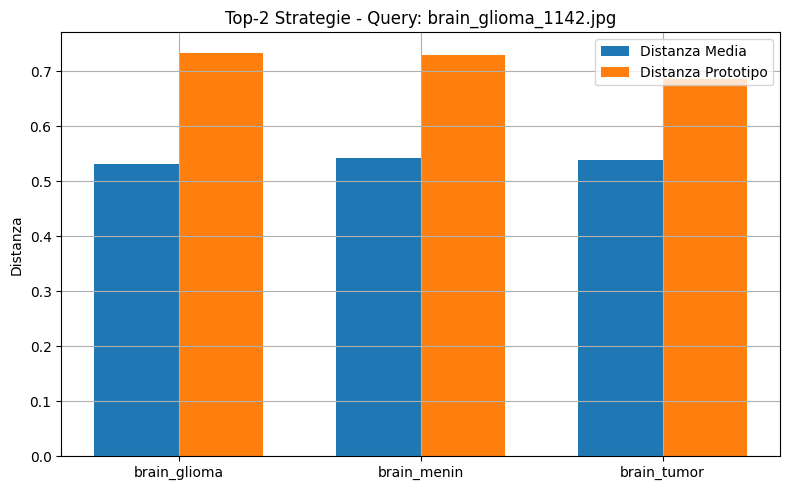


 Top-k etichette per ciascuna strategia:

Strategia: Distanza Media
label
brain_glioma    0.531493
brain_tumor     0.538370
Name: distance, dtype: float64

 Strategia: Prototipo di Classe
label
brain_tumor    0.685463
brain_menin    0.729260
dtype: float64


In [12]:
query_img = "Part2/brain_glioma/brain_glioma_1142.jpg"
compare_label_ranking_strategies(query_img, k=2)

Task 5

In [13]:

def task5_latent_semantics_hog(feature_model_path, technique, k):
    """
    Estrae i top-k concetti latenti da feature HOG tramite SVD, LDA o KMeans.
    Visualizza lo spazio latente ed esporta un file .txt con i pesi delle immagini.
    """
    # Caricamento feature, nomi file ed etichette
    data = np.load(feature_model_path)
    feature_matrix = data['features']
    filenames = data['filenames']
    labels = data['labels']

    technique = technique.lower()

    if technique == "svd":
        model = TruncatedSVD(n_components=k)
        X_transformed = model.fit_transform(feature_matrix)
        components = model.components_
        method = "svd"

    elif technique == "lda":
        unique_labels = np.unique(labels)
        max_k = min(k, len(unique_labels) - 1)
        if k > max_k:
            print(f"[ATTENZIONE] LDA supporta al massimo {max_k} componenti con {len(unique_labels)} classi.")
            k = max_k
        model = LDA(n_components=k)
        X_transformed = model.fit_transform(feature_matrix, labels)
        components = model.scalings_.T[:k]
        method = "lda"

    elif technique == "kmeans":
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(feature_matrix)
        components = model.cluster_centers_
        X_transformed = model.transform(feature_matrix)
        method = "kmeans"

    else:
        print("[ERRORE] Tecnica non supportata. Usa: 'svd', 'lda', 'kmeans'")
        return

    # Visualizzazione
    if technique in ["svd", "lda"]:
        plot_latent_space_2d(X_transformed, labels, technique, k)
    elif technique == "kmeans":
        plot_kmeans_clusters_2d(feature_matrix, labels, k)

    # Scrittura output
    base_name = os.path.splitext(os.path.basename(feature_model_path))[0]
    out_file = f"latent_semantics_{method}_{base_name}_k{k}.txt"

    with open(out_file, "w") as f:
        for i in range(k):
            f.write(f"\n--- Latent Semantic {i+1} ---\n")
            if technique in ["svd", "lda"]:
                weights = feature_matrix @ components[i].T
            else:  # KMeans: distanza inversa
                weights = -X_transformed[:, i]

            sorted_idx = np.argsort(-np.abs(weights))
            for idx in sorted_idx:
                f.write(f"{filenames[idx]} | Peso: {weights[idx]:.4f} | Classe: {labels[idx]}\n")

    print(f"[SALVATO] Latent semantics salvati in: {out_file}")

Visualizzazione 

In [14]:
def plot_latent_space_2d(X_transformed, labels, technique, k):
    """Visualizza la proiezione 2D delle immagini nello spazio latente (solo per SVD/LDA)."""
    if X_transformed.shape[1] < 2:
        print("[INFO] Meno di 2 componenti: impossibile visualizzare in 2D.")
        return

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_transformed[:, 0], y=X_transformed[:, 1], hue=labels, palette="Set2", s=80)
    plt.title(f"{technique.upper()} - Proiezione sulle prime 2 componenti latenti (k={k})")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_kmeans_clusters_2d(feature_matrix, labels, n_clusters):
    """Visualizza le immagini raggruppate da KMeans su uno spazio 2D ridotto con SVD."""
    svd = TruncatedSVD(n_components=2, random_state=42)
    X_2d = svd.fit_transform(feature_matrix)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(feature_matrix)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=cluster_labels, palette='tab10', s=80, style=labels)
    plt.title(f"KMeans Clustering (k={n_clusters}) con proiezione SVD 2D")
    plt.xlabel("Componente Latente 1 (da SVD)")
    plt.ylabel("Componente Latente 2 (da SVD)")
    plt.grid(True)
    plt.legend(title="Cluster")
    plt.show()


Esecuzione:

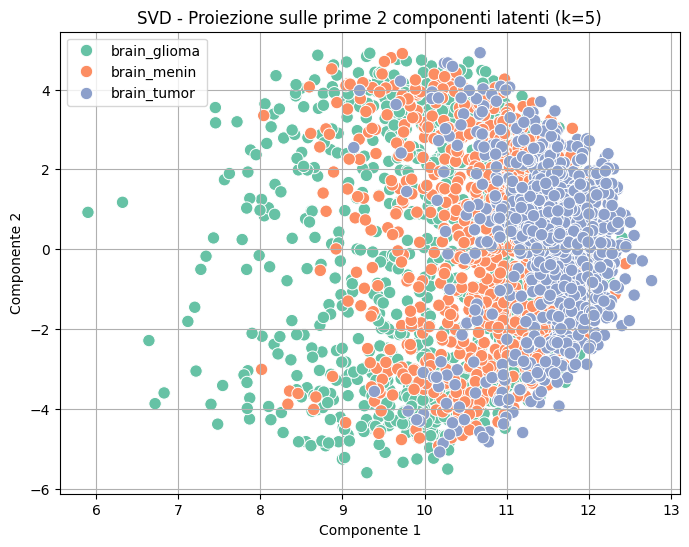

[SALVATO] Latent semantics salvati in: latent_semantics_svd_hog_features_part1_k5.txt


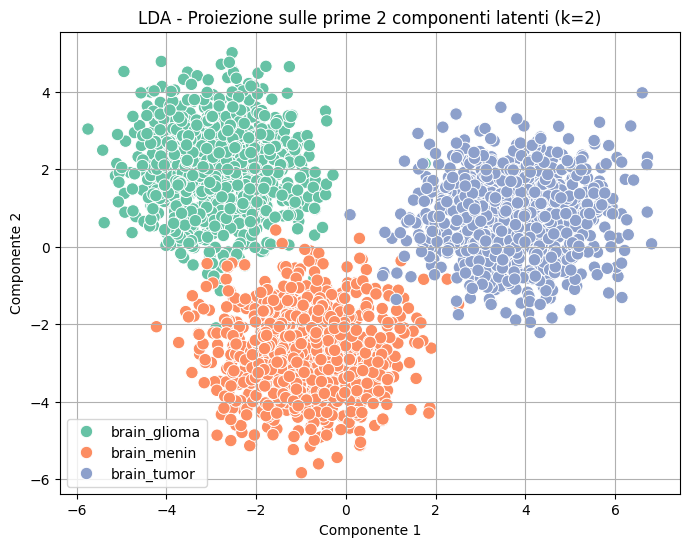

[SALVATO] Latent semantics salvati in: latent_semantics_lda_hog_features_part1_k2.txt


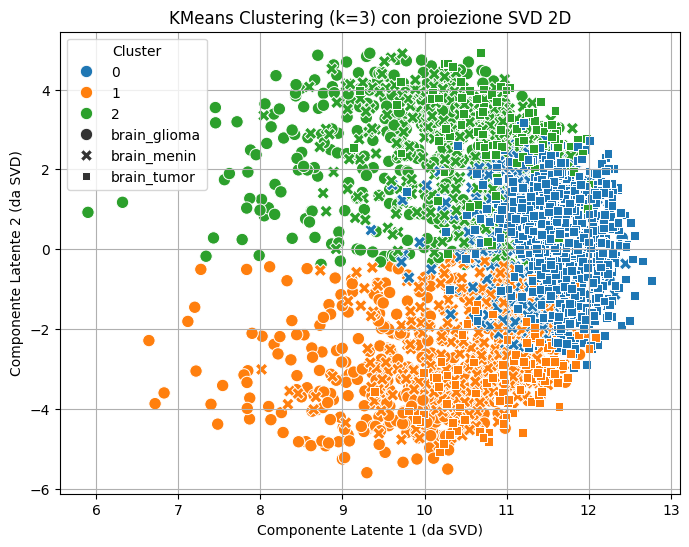

[SALVATO] Latent semantics salvati in: latent_semantics_kmeans_hog_features_part1_k3.txt


In [15]:
task5_latent_semantics_hog("hog_features_part1.npz", "svd", 5)
task5_latent_semantics_hog("hog_features_part1.npz", "lda", 2)
task5_latent_semantics_hog("hog_features_part1.npz", "kmeans", 3)


Task 6

In [16]:

def estimate_intrinsic_dimensionality(feature_matrix, threshold, plot=True):
    max_components = min(feature_matrix.shape)
    pca = PCA(n_components=max_components)
    pca.fit(feature_matrix)

    explained = pca.explained_variance_ratio_
    cumulative = np.cumsum(explained)
    intrinsic_dim = np.argmax(cumulative >= threshold) + 1

    #print(f"[INFO] Spiegazione varianza per ogni componente PCA:\n{explained}")
    #print(f"[INFO] Varianza cumulativa:\n{cumulative}")
    #print(f"[INFO] Soglia impostata: {threshold}")
    #print(f"[INFO] Dimensione intrinseca stimata: {intrinsic_dim}")

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(cumulative, marker='o', label="Varianza cumulativa")
        plt.axhline(y=threshold, color='r', linestyle='--', label=f"Soglia {threshold*100:.0f}%")
        plt.axvline(x=intrinsic_dim, color='g', linestyle='--', label=f"k suggerito: {intrinsic_dim}")
        plt.xlabel("Numero componenti")
        plt.ylabel("Varianza cumulativa")
        plt.title("Scelta ottimale di k (PCA/SVD)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    print(f"[INFO] k ottimale suggerito (soglia {threshold*100:.0f}%): {intrinsic_dim}")
    return intrinsic_dim, cumulative

def suggest_k(feature_matrix, threshold_list=[0.90, 0.95, 0.99]):
    print(f"[INFO] Feature matrix shape: {feature_matrix.shape}")
    k_values = {}
    for t in threshold_list:
        k, _ = estimate_intrinsic_dimensionality(feature_matrix, threshold=t, plot=False)
        k_values[t] = k
        print(f"Soglia {int(t*100)}% : k = {k}")
    return k_values


In [17]:
def estimate_dimensionality_per_label(feature_matrix, labels, threshold):
    label_dim_map = {}

    unique_labels = np.unique(labels)
    print(f"[INFO] Etichette uniche trovate: {len(unique_labels)}")

    for label in unique_labels:
        indices = np.where(labels == label)[0]
        label_features = feature_matrix[indices]

        if len(indices) < 2:
            print(f"[AVVISO] Label '{label}' ha meno di 2 campioni — ignorata.")
            continue

        k, _ = estimate_intrinsic_dimensionality(label_features, threshold=threshold, plot=False)
        label_dim_map[label] = k
        print(f" Label '{label}' : k = {k}")

    return label_dim_map


<>:2: SyntaxWarning: invalid escape sequence '\S'
<>:2: SyntaxWarning: invalid escape sequence '\S'
/var/folders/6q/jmt5rhf501363h2f7_4cnrjh0000gn/T/ipykernel_30569/1321706206.py:2: SyntaxWarning: invalid escape sequence '\S'
  print("\Stima automatica di k in base alla varianza spiegata:\n")


\Stima automatica di k in base alla varianza spiegata:

[INFO] Feature matrix shape: (3006, 8100)
[INFO] k ottimale suggerito (soglia 90%): 956
Soglia 90% : k = 956
[INFO] k ottimale suggerito (soglia 95%): 1360
Soglia 95% : k = 1360
[INFO] k ottimale suggerito (soglia 99%): 2174
Soglia 99% : k = 2174


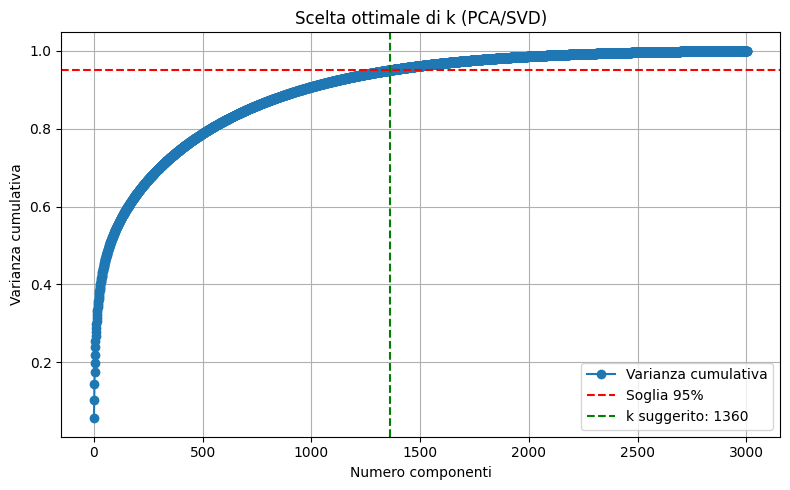

[INFO] k ottimale suggerito (soglia 95%): 1360

 Task 6b – Dimensionalità per etichetta:

[INFO] Etichette uniche trovate: 3
[INFO] k ottimale suggerito (soglia 95%): 679
 Label 'brain_glioma' : k = 679
[INFO] k ottimale suggerito (soglia 95%): 684
 Label 'brain_menin' : k = 684
[INFO] k ottimale suggerito (soglia 95%): 681
 Label 'brain_tumor' : k = 681


In [18]:
# Calcola k per varie soglie
print("\Stima automatica di k in base alla varianza spiegata:\n")
k_suggeriti = suggest_k(feat_matrix_part1)
# Plot dettagliato per la soglia 95%
estimate_intrinsic_dimensionality(feat_matrix_part1, threshold=0.95, plot=True)


print("\n Task 6b – Dimensionalità per etichetta:\n")
label_dimensionalities = estimate_dimensionality_per_label(feat_matrix_part1, lbls_part1, threshold=0.95)

Task7

In [19]:
def compute_latent_semantics_per_class(X, y, k=10):
    class_models = {}
    class_means = {}

    labels = np.unique(y)
    for label in labels:
        X_class = X[y == label]  # Prende solo le istanze della classe corrente
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_class)  # Normalizza i dati della classe

        svd = TruncatedSVD(n_components=k)
        latent = svd.fit_transform(X_scaled)  # Riduzione dimensionale con SVD

        # Salva modello SVD e scaler per la classe
        class_models[label] = {
            'svd': svd,
            'scaler': scaler,
            'latent_vectors': latent
        }
        # Calcola la media dei vettori latenti della classe
        class_means[label] = np.mean(latent, axis=0)
    return class_models, class_means

def predict_label(X_test, class_models, class_means):
    y_pred = []
    for x in X_test:
        best_label = None
        min_dist = float('inf')
        for label, model in class_models.items():
            x_scaled = model['scaler'].transform(x.reshape(1, -1))  # Normalizza x
            x_latent = model['svd'].transform(x_scaled)  # Trasforma in spazio latente
            dist = np.linalg.norm(x_latent - class_means[label])  # Distanza dal centroide
            if dist < min_dist:
                min_dist = dist
                best_label = label
        y_pred.append(best_label)
    return y_pred


def evaluate(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    labels = np.unique(y_true)
    print("Per-class metrics:")
    for i, label in enumerate(labels):
        print(
            f"Class {label}: P={precision[i]:.2f}, R={recall[i]:.2f}, F1={f1[i]:.2f}")
    print(f"\nOverall Accuracy: {accuracy:.2f}\n")

    print(classification_report(y_true, y_pred))


def evaluate_predictions(true_labels, predicted_labels):
    print("[VALUTAZIONE] Report di classificazione:")
    print(classification_report(true_labels, predicted_labels))

In [20]:
# Addestramento sui dati di Part1
class_models, class_means = compute_latent_semantics_per_class(
    feat_matrix_part1, lbls_part1, k=10)

# Predizione su Part2
predicted_labels = predict_label(feat_matrix_part2, class_models, class_means)

# Valutazione
evaluate(lbls_part2, predicted_labels)

Per-class metrics:
Class brain_glioma: P=0.63, R=0.42, F1=0.50
Class brain_menin: P=0.26, R=0.33, F1=0.29
Class brain_tumor: P=0.37, R=0.40, F1=0.39

Overall Accuracy: 0.38

              precision    recall  f1-score   support

brain_glioma       0.63      0.42      0.50      1002
 brain_menin       0.26      0.33      0.29      1002
 brain_tumor       0.37      0.40      0.39      1002

    accuracy                           0.38      3006
   macro avg       0.42      0.38      0.39      3006
weighted avg       0.42      0.38      0.39      3006



Task 8:

In [21]:
def apply_dbscan_with_pca(features, eps=2.0, min_samples=3, n_components=50):
    """
    Riduce 'features' a 'n_components' dimensioni con PCA, quindi applica DBSCAN
    e restituisce l'array di cluster-labels (interi) di lunghezza = numero di righe in 'features'.
    """
    print(f"[INFO] PCA -> Riduzione a {n_components} componenti")
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)

    scaler = StandardScaler()
    reduced_scaled = scaler.fit_transform(reduced_features)

    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(reduced_scaled)
    return labels


def top_c_clusters(cluster_labels, c):
    """
    cluster_labels: array di interi di lunghezza N.
    c: numero di cluster "più popolosi" che vogliamo restituire.
    Restituisce la lista dei c valori di cluster (escludendo -1) 
    ordinati in base alla dimensione (numero di occorrenze) decrescente.
    Se DBSCAN ha trovato meno di c cluster, restituisce tutti quelli disponibili.
    """
    # Conteggio delle occorrenze per ogni etichetta di cluster
    label_counts = Counter(cluster_labels)
    # Rimuovo il rumore (-1) se presente
    label_counts.pop(-1, None)
    
    if not label_counts:
        print("[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).")
        return []
    
    # Estraiamo i c cluster più frequenti
    most_common = label_counts.most_common(c)  # es. [(label1, count1), (label2, count2), ...]
    top = [int(lbl) for lbl, _ in most_common]
    
    # Se DBSCAN ha trovato meno di c cluster, most_common contiene già tutti
    if len(top) < c:
        print(f"[WARN] DBSCAN ha trovato solo {len(top)} cluster (meno di {c}).")
    return top


def plot_mds_clusters(features, cluster_labels, top_clusters, metric='euclidean'):
    """
    features: array (N, d) delle tue feature originali (senza aver fatto PCA).
    cluster_labels: array (N,) con i risultati DBSCAN.
    top_clusters: lista di interi pari ai cluster "significativi" (col più grandi).
    metric: la distanza da usare per MDS (default 'euclidean').
    Mostra un grafico 2D (scatter) con i punti appartenenti ai top_clusters colorati diversamente,
    tutti gli altri (cluster minori o -1) in grigio chiaro.
    """
    # 1) Normalizzo / scalizzo le features originali
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 2) Calcolo la matrice di distanze (facoltativo) e poi MDS → Y (N×2)
    #    Qui usiamo MDS “direttamente” su features_scaled, che di default assume euclidea.
    mds = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
    Y = mds.fit_transform(features_scaled)

    # 3) Plotto i punti
    import matplotlib
    cmap= matplotlib.colormaps['tab10']

    plt.figure(figsize=(6, 6))
    for i in range(len(Y)):
        lbl = cluster_labels[i]
        if lbl in top_clusters:
            color_idx = top_clusters.index(lbl)
            plt.scatter(Y[i,0], Y[i,1], color=cmap(color_idx), s=30, edgecolor='k', linewidth=0.2)
        else:
            # punti rumore o cluster “non top”
            plt.scatter(Y[i,0], Y[i,1], color='lightgray', s=8)

    plt.title(f"MDS 2D – Top {len(top_clusters)} cluster")
    plt.xlabel("MDS 1")
    plt.ylabel("MDS 2")
    plt.tight_layout()
    plt.show()


def show_cluster_thumbnails(images, cluster_labels, top_clusters, thumb_size=(64, 64)):
    """
    images: lista (o array) di percorsi file (lunghezza N), 
            ossia a images[i] corrisponde features[i].
    cluster_labels: array (N,) di cluster per ogni immagine.
    top_clusters: lista dei c cluster (int) che vogliamo visualizzare.
    thumb_size: dimensione (w,h) di ogni miniatura.
    Per ogni cluster ∈ top_clusters stampa a video (o fa plt.show) 
    una griglia di miniature (fino a ~16‐25 alla volta).
    """
    for cluster_id in top_clusters:
        # Indici di tutte le immagini che appartengono a questo cluster
        idxs = [i for i, cl in enumerate(cluster_labels) if cl == cluster_id]
        print(f"[INFO] Cluster {cluster_id}: {len(idxs)} immagini trovate")

        # Se vogliamo limitare a N miniatura per cluster (tipo 16):
        max_display = min(len(idxs), 16)
        n = int(np.ceil(np.sqrt(max_display)))  # facciamo una griglia n×n
        plt.figure(figsize=(n, n))

        for j, i_img in enumerate(idxs[:max_display]):
            img = Image.open(images[i_img]).convert('RGB')
            img_thumb = img.resize(thumb_size, Image.LANCZOS)


            ax = plt.subplot(n, n, j+1)
            plt.imshow(img_thumb)
            plt.axis('off')

        plt.suptitle(f"Cluster {cluster_id} – {len(idxs)} immagini (mostrate: {max_display})")
        plt.tight_layout()
        plt.show()



[INFO] Elaboro label: brain_glioma
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1]
[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).
[INFO] Top 3 cluster (per dimensione): []
[INFO] Disegno MDS 2D per i cluster di 'brain_glioma' …


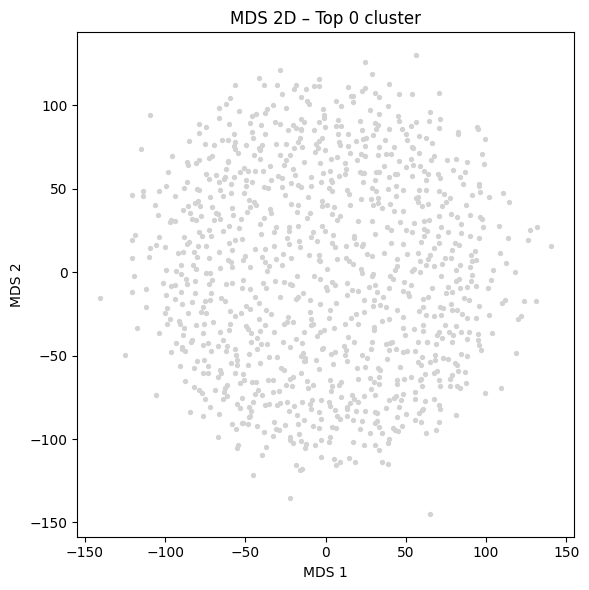

[INFO] Genero miniature per ciascun cluster di 'brain_glioma' …

[INFO] Elaboro label: brain_menin
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1]
[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).
[INFO] Top 3 cluster (per dimensione): []
[INFO] Disegno MDS 2D per i cluster di 'brain_menin' …


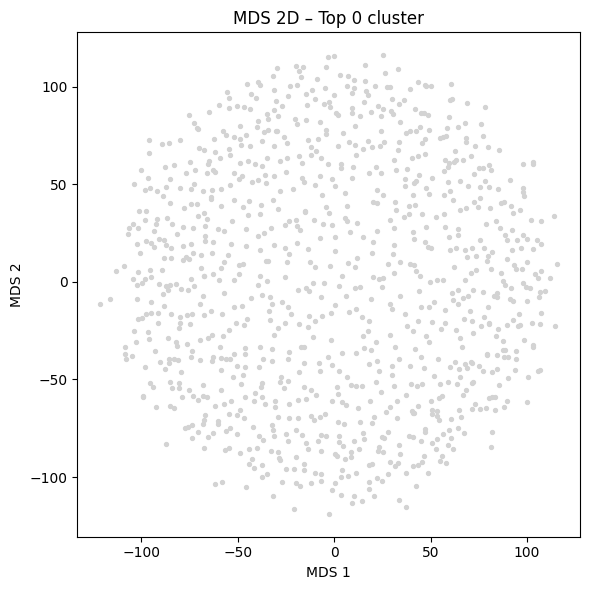

[INFO] Genero miniature per ciascun cluster di 'brain_menin' …

[INFO] Elaboro label: brain_tumor
[INFO] PCA -> Riduzione a 50 componenti
[INFO] Cluster-labels trovati: [-1]
[WARN] DBSCAN non ha trovato alcun cluster valido (solo rumore).
[INFO] Top 3 cluster (per dimensione): []
[INFO] Disegno MDS 2D per i cluster di 'brain_tumor' …


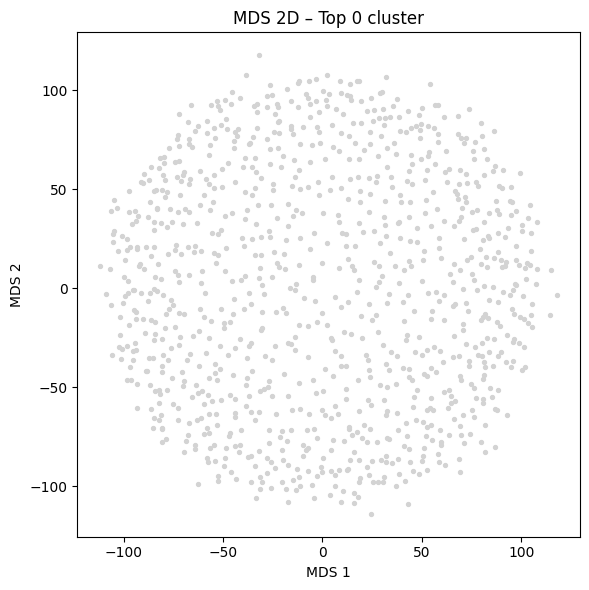

[INFO] Genero miniature per ciascun cluster di 'brain_tumor' …

[FINITO] Task 8 completato per tutte le label di Parte1.


In [22]:
# ================================
# BLOCCHETTO PER TASK 8 (RIUSO FUNZIONI)
# ================================

# 3) PARAMETRI (modificabili a piacere)
eps = 2.0            # valore DBSCAN di esempio
min_samples = 3      # valore DBSCAN di esempio
n_components = 50    # quante dimensioni tenere con PCA PRIMA di DBSCAN
c = 3                # quanti cluster “significativi” voglio prendere per ciascuna label

# 4) Creare una cartella di output (facoltativo)
output_base = "./results_task8"
os.makedirs(output_base, exist_ok=True)

# 3) Costruisco l’elenco dei full path per tutte le immagini
base_folder = "Part1"  # o path assoluto "/Users/.../Parte1"
images_full = [ os.path.join(base_folder, lbl, fname)
                for fname, lbl in zip(flname_part1, lbls_part1) ]

# 5) SCORRO OGNI LABEL DI Parte1 E APPLICO DBSCAN+PCA
unique_labels = np.unique(lbls_part1)  # es. ["Glioma","Meningioma","Pituitary"]

for lbl in unique_labels:
    print(f"\n==============================")
    print(f"[INFO] Elaboro label: {lbl}")
    print(f"==============================")

    # 5.1) Estraggo le righe di feat_matrix_part1 / flname_part1 corrispondenti
    mask_lbl = (lbls_part1 == lbl)
    features_label = feat_matrix_part1[mask_lbl]   # shape = (n_i, d)
    images_label   = np.array(images_full)[mask_lbl]

    # 5.2) Chiamo la tua funzione che fa PCA + DBSCAN
    cluster_labels = apply_dbscan_with_pca(
        features_label,
        eps=eps,
        min_samples=min_samples,
        n_components=n_components
    )
    print(f"[INFO] Cluster-labels trovati: {np.unique(cluster_labels)}")

    # 5.3) Trovo i c cluster più grandi
    top_clusters = top_c_clusters(cluster_labels, c)
    print(f"[INFO] Top {c} cluster (per dimensione): {top_clusters}")

    # 5.4) Creo sotto-cartella di output per questa label
    out_dir_lbl = os.path.join(output_base, f"label_{lbl}")
    os.makedirs(out_dir_lbl, exist_ok=True)

    # 5.5) MDS‐2D + scatter plot del clustering
    print(f"[INFO] Disegno MDS 2D per i cluster di '{lbl}' …")
    # (ATTENZIONE: plot_mds_clusters in genere “fa plt.show()” a video.
    #  Se vuoi salvare l’immagine invece di far vedere a notebook, 
    #  devi modificare leggermente quella funzione per usare plt.savefig())
    plot_mds_clusters(
        features_label,
        cluster_labels,
        top_clusters,
        metric='euclidean'
    )
    # Se invece vuoi **salvare** l’immagine in PNG anziché fare “show()”:
    #    plt.savefig(os.path.join(out_dir_lbl, f"{lbl}_MDS_clusters.png"))
    #    plt.close()

    # 5.6) Creo le miniature di ogni cluster “significativo”
    print(f"[INFO] Genero miniature per ciascun cluster di '{lbl}' …")
    show_cluster_thumbnails(
        images_label,      # array di stringhe di percorsi
        cluster_labels,    # array di int di lunghezza n_i
        top_clusters,      # la lista dei c indici di cluster
        thumb_size=(64, 64)
    )
    # Anche qui, di default quella funzione fa plt.show() per ogni cluster.
    # Se vuoi salvare le figure in file, modifica show_cluster_thumbnails in
    # modo che setti un outpath e faccia plt.savefig().

print("\n[FINITO] Task 8 completato per tutte le label di Parte1.")


Task 9

In [23]:


# Imposta il valore di m per l'm-NN
m = 5  # Modifica questo valore in base alle tue necessità

# Addestramento m-NN
knn_model = KNeighborsClassifier(n_neighbors=m)
knn_model.fit(feat_matrix_part1, lbls_part1)

# Addestramento Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(feat_matrix_part1, lbls_part1)

# Predizioni su Part2
pred_knn = knn_model.predict(feat_matrix_part2)
pred_dt = dt_model.predict(feat_matrix_part2)

# Valutazione m-NN
print("Risultati m-NN:")
print(classification_report(lbls_part2, pred_knn))
print("Accuratezza complessiva m-NN:", accuracy_score(lbls_part2, pred_knn))

# Valutazione Decision Tree
print("Risultati Decision Tree:")
print(classification_report(lbls_part2, pred_dt))
print("Accuratezza complessiva Decision Tree:", accuracy_score(lbls_part2, pred_dt))


Risultati m-NN:
              precision    recall  f1-score   support

brain_glioma       0.71      0.85      0.77      1002
 brain_menin       0.80      0.49      0.61      1002
 brain_tumor       0.78      0.93      0.85      1002

    accuracy                           0.76      3006
   macro avg       0.76      0.76      0.74      3006
weighted avg       0.76      0.76      0.74      3006

Accuratezza complessiva m-NN: 0.7564870259481038
Risultati Decision Tree:
              precision    recall  f1-score   support

brain_glioma       0.66      0.65      0.65      1002
 brain_menin       0.50      0.49      0.49      1002
 brain_tumor       0.62      0.65      0.64      1002

    accuracy                           0.60      3006
   macro avg       0.59      0.60      0.60      3006
weighted avg       0.59      0.60      0.60      3006

Accuratezza complessiva Decision Tree: 0.5958083832335329


Task 10


In [24]:
# Classe LSH con quantizzazione

class LSH_EuclideanQuantized:
    """
    LSH per distanza Euclidea (p-stable) con bucket width r.
    Ogni hash h_j(v) = floor((a_j · v + b_j) / r).

    Parametri:
      - num_layers   = L = numero di tavole hash
      - num_hashes   = h = numero di functions concatenati in ciascuna tavola
      - dim          = D = dimensione dei vettori di input
      - r            = bucket width (parte intera di quantizzazione)
    """

    def __init__(self, num_layers: int, num_hashes: int, dim: int, r: float):
        self.L = num_layers
        self.h = num_hashes
        self.d = dim
        self.r = r

        # Prepara L tavole hash: ciascuna è un dict (chiave tuple di h interi -> lista di indici)
        self.hash_tables = [defaultdict(list) for _ in range(self.L)]

        # Per ogni layer l=0..L-1, e per ogni j=0..h-1, genero:
        #   - a_lj  vettore gaussiano di dimensione D
        #   - b_lj  offset (uniforme in [0, r) )
        self.a_vectors = [
            [np.random.randn(self.d) for _ in range(self.h)]
            for _ in range(self.L)
        ]
        self.b_offsets = [
            [np.random.uniform(0, self.r) for _ in range(self.h)]
            for _ in range(self.L)
        ]

        # Memorizzerò i vettori originali di Part1 in questo array, shape=(N, D)
        self.data_vectors = None

    def _compute_hash_tuple(self, vec: np.ndarray, layer_idx: int) -> tuple:
        """
        Calcola l'hash (h interi) per il layer layer_idx su un vettore vec:
          h_j = floor((a_vectors[layer_idx][j] · vec + b_offsets[layer_idx][j]) / r)
        Ritorna una tupla di h interi.
        """
        keys = []
        a_vs = self.a_vectors[layer_idx]
        b_os = self.b_offsets[layer_idx]
        for j in range(self.h):
            a_j = a_vs[j]         # vettore dimensione D
            b_j = b_os[j]         # float in [0, r)
            proj = float(np.dot(a_j, vec) + b_j)
            h_val = int(np.floor(proj / self.r))
            keys.append(h_val)
        return tuple(keys)

    def index(self, vectors: np.ndarray):
        """
        Costruisci l'indice LSH su un insieme di vettori di Part1:
          vectors: numpy array shape = (N, D)
        Al termine di questa chiamata:
          - self.data_vectors = vectors
          - self.hash_tables[l][hash_tuple] conterrà la lista di indici i per cui
            hash_tuple = _compute_hash_tuple(vectors[i], l).
        """
        self.data_vectors = vectors
        N, D = vectors.shape
        assert D == self.d, f"Errore: dimensione vettore ({D}) ≠ atteso ({self.d})."

        # Inserisco ogni vettore in ciascuna tavola hash
        for idx in range(N):
            v = vectors[idx]
            for l in range(self.L):
                key = self._compute_hash_tuple(v, l)
                self.hash_tables[l][key].append(idx)

    def query(self, q_vec: np.ndarray, top_t: int = 5):
        """
        Esegui una query LSH per cercare i top_t vettori più vicini a q_vec.
        Restituisce:
          - top_results: lista di tuple (indice, distanza) ord. per dist. crescente
          - unique_count: numero di indici distinti considerati (cardinalità dei candidati)
          - total_checked: somma della lunghezza di tutti i bucket esaminati
        """
        assert q_vec.shape[0] == self.d, "Errore: dimensione query ≠ D."
        candidati = set()
        total_checked = 0

        # Per ciascun layer, ottengo la chiave polidimensionale e i suoi bucket
        for l in range(self.L):
            h_tuple = self._compute_hash_tuple(q_vec, l)
            bucket = self.hash_tables[l].get(h_tuple, [])
            total_checked += len(bucket)
            candidati.update(bucket)

        # Ora calcolo la distanza euclidea esatta tra q_vec e ciascun candidato
        risultati = []
        for idx in candidati:
            v_i = self.data_vectors[idx]
            dist = np.linalg.norm(v_i - q_vec)
            risultati.append((idx, dist))

        # Ordino e prendo i primi top_t
        risultati.sort(key=lambda x: x[1])
        top_results = risultati[:top_t]
        return top_results, len(candidati), total_checked


In [25]:
# costruzione LSH_EuclideanQuantized su Part1

# 1) (Opzionale ma consigliato) centra e normalizza i vettori di Part1
#    Questo passaggio riduce l'effetto di scale diverse e spesso migliora la qualità LSH
mean_vec = np.mean(feat_matrix_part1, axis=0)
feat_centered = feat_matrix_part1 - mean_vec
feat_normed = normalize(feat_centered, norm='l2', axis=1)

# 2) Parametri LSH
D = feat_normed.shape[1]      # di solito 900
L = 10                         # numero di tavole hash (scegli in base a esperimenti)
h = 7                      # numero di funzioni concatenati in ciascuna tavola
r = 1                       # parametro di larghezza (esempio: 0.5); puoi sperimentare

# 3) Creo l'oggetto e indicizzo
lsh_quant = LSH_EuclideanQuantized(num_layers=L, num_hashes=h, dim=D, r=r)
lsh_quant.index(feat_normed)

print(f"[INFO] LSH quantizzato costruito: D={D}, L={L}, h={h}, r={r}")


[INFO] LSH quantizzato costruito: D=8100, L=10, h=7, r=1


In [26]:
#funzione per cercare top_k con LSH quantizzato

def find_k_similar_lsh_quant(base_folder: str, img_path: str, k: int):
    """
    Cerca le k immagini di Part1 più simili a img_path (di Part2) usando LSH_EuclideanQuantized.
    Stampa:
      - i primi k risultati (file name, label, distanza)
      - il numero di immagini uniche considerate
      - il numero totale di controlli (somma delle lunghezze dei bucket)
    E poi visualizza (query + k risultati) con matplotlib.
    """
    # 1) Estrazione feature raw (900-dim) con la funzione esistente
    raw_q = np.array(extract_hog_features_from_image(img_path), dtype=np.float32)

    # 2) Center + normalize (stesso mean_vec e L2 norm usati su Part1)
    q_centered = raw_q - mean_vec
    q_normed = q_centered / np.linalg.norm(q_centered)

    # 3) Chiamata a LSH
    top_results, unique_count, total_checked = lsh_quant.query(q_normed, top_t=k)

    # 4) Stampa output testuale
    print(f"\n[LSH-Quant] Top {k} simili a: {img_path}")
    for rank, (idx, dist) in enumerate(top_results, start=1):
        label = lbls_part1[idx]
        fname = flname_part1[idx]
        print(f"  {rank}. {fname} | Classe: {label} | Distanza Euclidea: {dist:.2f}")
    print(f"[LSH-Quant] Immagini uniche considerate: {unique_count}")
    print(f"[LSH-Quant] Immagini totali controllate: {total_checked}")

    # 5) Visualizzazione (query + primi k risultati)
    fig, axs = plt.subplots(1, k+1, figsize=(4*(k+1), 4))
    img_q = cv2.imread(img_path)
    img_q = cv2.cvtColor(img_q, cv2.COLOR_BGR2RGB)
    axs[0].imshow(img_q)
    axs[0].set_title("Query (LSH-Quant)")
    axs[0].axis('off')

    for i, (idx, dist) in enumerate(top_results, start=1):
        lab = lbls_part1[idx]
        fname = flname_part1[idx]
        full_path = os.path.join(base_folder, lab, fname)
        img_match = cv2.imread(full_path)
        img_match = cv2.cvtColor(img_match, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img_match)
        axs[i].set_title(f"Rank {i}\nd={dist:.2f}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()



[LSH-Quant] Top 5 simili a: Part2/brain_glioma/brain_glioma_1409.jpg
  1. brain_glioma_0787.jpg | Classe: brain_glioma | Distanza Euclidea: 1.14
  2. brain_tumor_0770.jpg | Classe: brain_tumor | Distanza Euclidea: 1.26
  3. brain_glioma_0226.jpg | Classe: brain_glioma | Distanza Euclidea: 1.27
  4. brain_tumor_0641.jpg | Classe: brain_tumor | Distanza Euclidea: 1.30
  5. brain_menin_0474.jpg | Classe: brain_menin | Distanza Euclidea: 1.34
[LSH-Quant] Immagini uniche considerate: 7
[LSH-Quant] Immagini totali controllate: 7


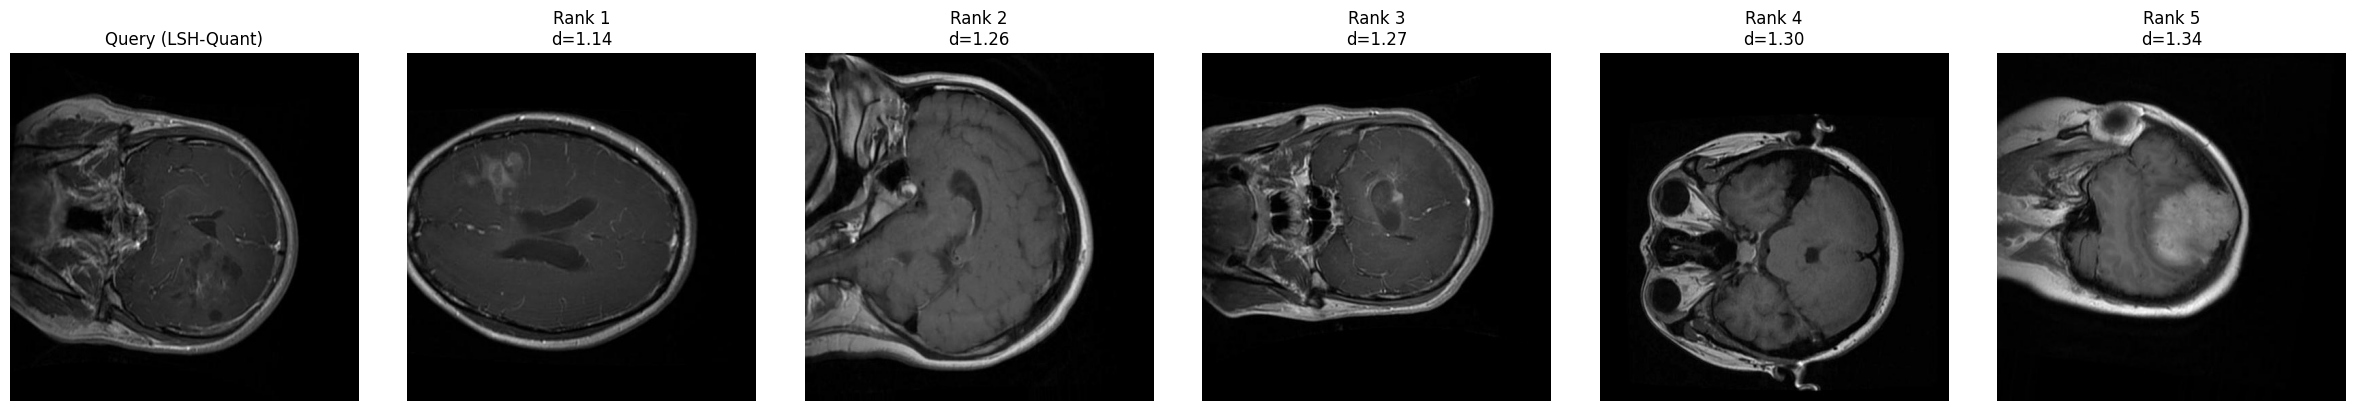

In [27]:
# Esempio di utilizzo su un'immagine di Part2 ---
query_path = "Part2/brain_glioma/brain_glioma_1409.jpg"

k = 5                         # numero di immagini simili da visualizzare

# Eseguo la ricerca LSH
find_k_similar_lsh_quant("Part1", query_path, k)
